In [28]:
import copy
import random
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import math
import torchvision.transforms as T
import numpy as np
import time
import socket
from IPython.display import clear_output

In [29]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim))
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr) #cambiar
        
    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        tensor = torch.Tensor(state)
        y_pred = self.model(tensor)
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

state_dim -> input red nuronal, depende del estado

action_dim -> 4 acciones: up, down, left y right

hidden_dim -> ajustar hiperparámetro

lr -> ajustar hiperparámetro

In [30]:
action_dim = 4
hidden_dim = 200
lr = 0.05

In [31]:
state_dim = 4

In [32]:
model = DQN(state_dim, action_dim, hidden_dim, lr)

### Prueba preliminar
Distancia a la pill más cercana en cada una de las direcciones.

In [33]:
episodes = 100
gamma = 0.7

In [34]:
class Game():
    def __init__(self, host="localhost", port=38514, numEpisodes = 100):
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.episodes = numEpisodes
        try:
            self.sock.bind((host, port))
        except socket.error as err:
            print('Bind failed. Error Code : ' .format(err))
        
    def connect(self):
        self.sock.listen(1)
        self.conn, _ = self.sock.accept()
        self.conn.send(bytes(str(self.episodes) + "\n",'UTF-8'))
        
    def get_state(self):
        data = self.conn.recv(512)
        data = data.decode(encoding='UTF-8')
        lista=data.split(";")
        reward= int(lista[1])
        #print(data)
        if lista[0] == "gameOver":
            return None, reward
        next_state=list(map(int, lista[0].replace("[","").replace("]","").split(",")))
        return next_state,reward
    
    def send_action(self, action):
        self.conn.send(bytes(str(action) + "\n",'UTF-8'))

In [35]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(500, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(500, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [36]:
def q_learning(model, episodes = 100, gamma=0.7, epsilon=0.3, title = 'DQN'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game(numEpisodes = episodes)
    game.connect()
    final = []
    q_values = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
                
        # Reset state
        state, _ = game.get_state()
        
        total = 0
        
        while True:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            game.send_action(action)
            next_state, reward = game.get_state()    
           
            
            # Update total
            total += reward
            if type(q_values) != list:
                q_values = q_values.tolist()
            else:
                 q_values = model.predict(state).tolist()
            
            if next_state is None:
                q_values[action] = reward
                # Update network weights
                model.update(state, q_values)
                break
            
            q_values_next = model.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            model.update(state, q_values)
            
            state = next_state
            
        
        final.append(total)
        plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        #torch.save(model, "model.mdl")
    return sum(final) / len(final)

In [37]:
def q_learning_old(model, episodes = 100, gamma=0.7, epsilon=0.3, title = 'DQN'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game(numEpisodes = episodes)
    game.connect()
    final = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
                
        # Reset state
        state = game.get_state()
        
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            q_values = model.predict(state) #Devuelve array con probabilidades de accion
            #action = torch.argmax(q_values).item() #Accion a realizar
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            next_state, reward, done = game.step(action) #Quizas reward requiera tratamiento, 
            
            #print("Action:" , action)
           #print("next_state", next_state)
            #print("reward", reward)
            #print("done", done)
            
            # Update total and memory
            total += reward
            q_values = q_values.tolist()
             
            if done:
                q_values[action] = reward
                # Update network weights
                model.update(state, q_values)
                break
                
            # Update network weights using the last step only
            q_values_next = model.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            model.update(state, q_values)
            
            state = game.get_state()
            #state = next_state
        
        final.append(total)
        #plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        #if total == 500:
            #torch.save(model, "model.mdl")
            #return final
    return final
    
    

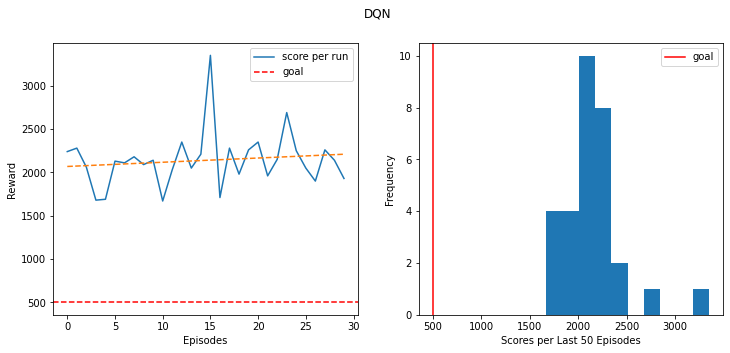

2139.0

In [38]:
q_learning(model, episodes=30, epsilon=1)

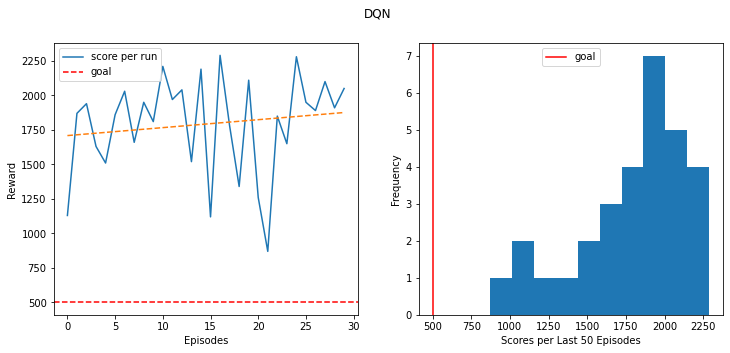

1792.3333333333333

In [39]:
q_learning(model, episodes=30, epsilon=0.1)

In [40]:
class DQN_replay(DQN):
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory) >= size:
            batch = random.sample(memory,size)
            
            batch_t = list(map(list, zip(*batch))) #Transpose batch list

            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

In [41]:
def q_learning_replay(model, episodes=100, gamma=0.7, epsilon=0.3, replay_size=20, title='DQN Replay'):
    """Deep Q Learning algorithm using the DQN. """
    game = Game(numEpisodes = episodes)
    game.connect()
    final = []
    q_values = []
    memory = []
    episode_i=0
    for episode in range(episodes):
        episode_i+=1
        intersecciones = 1     
        # Reset state
        state, _ = game.get_state()
        
        total = 0
        
        while True:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0,3)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
                
            # Take action and add reward to total
            game.send_action(action)
            next_state, reward = game.get_state()
            intersecciones += 1
            # Update total
            total += reward
            if type(q_values) != list:
                q_values = q_values.tolist()
            else:
                 q_values = model.predict(state).tolist()

            if next_state is None:
                break

            memory.append((state, action, next_state, reward, next_state is None))
            
            model.replay(memory, replay_size, gamma)
            
            state = next_state
        
        final.append(total)
        plot_res(final, title)
        
        #print("episode: {}, total reward: {}".format(episode_i, total))
            
        torch.save(model, "model.mdl")
    return sum(final)/len(final)

In [42]:
model = DQN_replay(state_dim, action_dim, hidden_dim, lr)

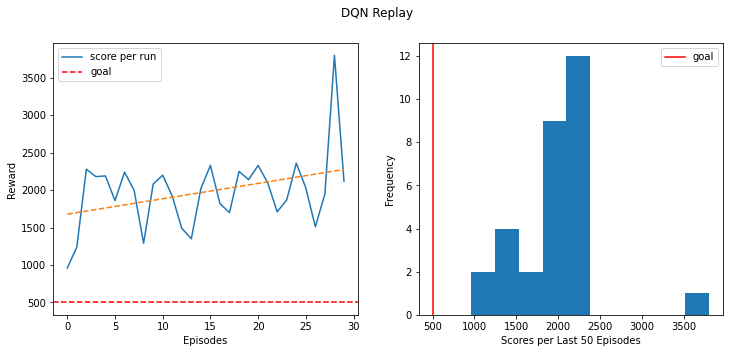

1977.3333333333333

In [49]:
q_learning_replay(model, episodes=30, epsilon=0.1, replay_size=340)

Hiperparámetros a ajustar:
* Learning rate
* Hidden dimension
* Number of episodes
* Epsilon
* Gamma

Específica del replay DQN
* Replay size

In [44]:
def adjust_parameters(episodes=(100, 1000, 10), hidden_layers=(100, 1000, 10), epsilon=(0.01, 0.1, 10), gamma=(0.5, 1, 10), lr=(0.01, 0.1, 5)):
    means = []

    episodes_list = np.linspace(episodes[0], episodes[1], episodes[2]).astype(int).tolist()
    hidden_layers_list = np.linspace(hidden_layers[0], hidden_layers[1], hidden_layers[2]).astype(int).tolist()
    epsilon_list = np.linspace(epsilon[0], epsilon[1], epsilon[2]).tolist()
    gamma_list = np.linspace(gamma[0], gamma[1], gamma[2]).tolist()
    lr_list = np.linspace(lr[0], lr[1], lr[2]).tolist()

    for episode in episodes_list:
        for hidden_layer in hidden_layers_list:
            for eps in epsilon_list:
                for gam in gamma_list:
                    for l in lr_list:
                        model = DQN(4, 4, hidden_layer, l)
                        mean = q_learning(model, episodes=episode, gamma=gam, epsilon=eps)
                        print(mean)
                        means.append((mean, episode, hidden_layer, eps, gam, l))

    return means



In [45]:
#adjust_parameters(episodes=(100, 1000, 2), hidden_layers=(100, 1000, 2), epsilon=(0.01, 0.1, 2), gamma=(0.5, 1, 2), lr=(0.01, 0.1, 2))